<a href="https://colab.research.google.com/github/mancinimassimiliano/DeepLearningLab/blob/master/non_centered_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

In this notebook we will see the effect of translating MNIST digits on the classification accuracy when a MLP is used for training. 

In details, we will shift the digits horizontally and/or vertically in an image and monitor their impact on training and the final performance of the network. For eg. if we shift a digit "five" to one corner of the image, can the MLP network still identify it as a digit "five"?

In [0]:
import torch
import torchvision
from torchvision import transforms as T
import torch.nn.functional as F

# Libraries needed for visualization purposes
from tensorboardcolab import TensorBoardColab
import matplotlib.pyplot as plt

# Instantiate Tensorboard visualizer
# TODO 

### Define the 'translation' transformation function that generates the *custom* translated MNIST dataset.

Useful links:

[`torch.randint`](https://pytorch.org/docs/stable/torch.html#torch.randint) for generating random integers.

[`torch.nn.functional.pad`](https://pytorch.org/docs/stable/nn.html#torch.nn.functional.pad) for padding zeros to images.

[`torchvision.transforms.Lambda`](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Lambda) for applying user-defined lambda as a function.



In [0]:
# This function will shift digits horizontally and/or vertically, i.e., translation transformation
def apply_translation_transform():
  def padding(x):
      # this function will add random zero padding to the MNIST digits
      pad_size = 28
      left_padding = # TODO
      top_padding = #TODO
      return # TODO
  
  # We would apply a list of transformations, sequentially
  translation_transform = list()
  translation_transform.append(T.ToTensor())
  # TODO for padding zero values around digits
  # TODO repeat channels just for the sake of matplotlib visualization
  # TODO combine all the desired transformations
  
  return translation_transform

### Function for Dataset Visualization
This function loads a batch of images which have been translated horizontally or vertically

In [0]:
def get_data_for_visualization(batch_size, translate=False): 
  
  if not translate:
    # Image transformation that appends 7 pixels on each side of a digit
    transform = list()
    transform.append(T.ToTensor())
    # TODO for padding zero values uniformly on all sides, so that the digits are still at the center
    # TODO combine all the desired transformations
  else:
    # Applies random translations to images
    transform = apply_translation_transform()

  # Load data
  full_training_data = torchvision.datasets.MNIST('./data', train=True, transform=transform, download=True)

  # Initialize dataloaders
  train_loader = torch.utils.data.DataLoader(full_training_data, batch_size, shuffle=True)
  
  return train_loader

### Visualize both translated and non-translated MNIST digits

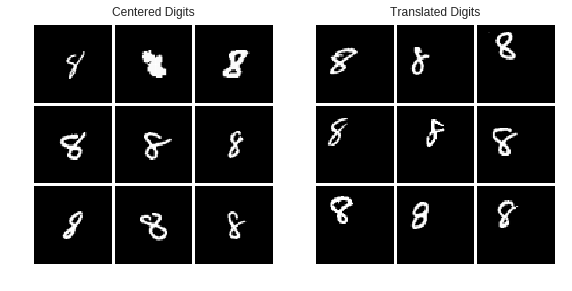

In [0]:
# Get a bunch of training images for visualization
train_loader = get_data_for_visualization(256, translate=False)
train_loader_translated = get_data_for_visualization(256, translate=True)

train_iter, train_iter_translated = iter(train_loader), iter(train_loader_translated)

# Get a single batch of data and labels of centered digits
data, labels = next(train_iter)

# Get a single batch of data and labels of translated digits
data_translated, labels_translated = next(train_iter_translated)

# the label of the digit you want to visualize
digit_label = 8

# get first 9 indices of the chosen digit for non-translated digits
get_idx = (labels == digit_label).nonzero().squeeze(-1)[0:9]

# get first 9 indices of the chosen digit for translated digits
get_idx_translated = (labels_translated == digit_label).nonzero().squeeze(-1)[0:9]

# this gets the data and labels for the chosen certain digit
get_data, get_labels = data[get_idx, :, :, :], labels[get_idx]
get_data_translated, get_labels_translated = data_translated[get_idx_translated, :, :, :], \
                                             labels_translated[get_idx_translated]


# visualize the plots inline, both for translated and non-translated
# first the non-translated digits
display_grid = torchvision.utils.make_grid(get_data, nrow=3, padding=2, pad_value=1)
plt.subplot(1, 2, 1)
plt.imshow(display_grid.numpy().transpose(1,2,0))
plt.axis('off')
plt.title('Centered Digits')

# the the translated digits
display_grid_translated = torchvision.utils.make_grid(get_data_translated, nrow=3, padding=2, pad_value=1)
plt.subplot(1, 2, 2)
plt.imshow(display_grid_translated.numpy().transpose(1,2,0))
plt.axis('off')
plt.title('Translated Digits')

plt.tight_layout()
plt.show()




### Define our first MLP

In [0]:
# Our previous MLP
class MyFirstNetwork(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(MyFirstNetwork, self).__init__()
    
    self.input_to_hidden = torch.nn.Linear(input_dim, hidden_dim)
    self.hidden_to_output = torch.nn.Linear(hidden_dim, output_dim)
    self.activation = torch.nn.Sigmoid()
    
    self.input_to_hidden.bias.data.fill_(0.)
    self.hidden_to_output.bias.data.fill_(0.)

  def forward(self, x):
    x = x.view(x.shape[0],-1)
    x = self.input_to_hidden(x)
    x = self.activation(x)
    x = self.hidden_to_output(x)
    return x

### Define cost function

In [0]:
def get_cost_function():
  cost_function = torch.nn.CrossEntropyLoss()
  return cost_function

### Define the optimizer

In [0]:
def get_optimizer(net, lr, wd, momentum):
  optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd, momentum=momentum)
  return optimizer

### Train and test functions

In [0]:
def test(net, data_loader, cost_function, device='cuda:0'):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  net.eval() # Strictly needed if network contains layers which has different behaviours between train and test
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(data_loader):
      # Load data into GPU
      inputs = inputs.to(device)
      targets = targets.to(device)
        
      # Forward pass
      outputs = net(inputs)

      # Apply the loss
      loss = cost_function(outputs, targets)

      # Better print something
      samples+=inputs.shape[0]
      cumulative_loss += loss.item() # Note: the .item() is needed to extract scalars from tensors
      _, predicted = outputs.max(1)
      cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100

def train(net,data_loader,optimizer,cost_function, device='cuda:0'):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  
  net.train() # Strictly needed if network contains layers which has different behaviours between train and test
  for batch_idx, (inputs, targets) in enumerate(data_loader):
    # Load data into GPU
    inputs = inputs.to(device)
    targets = targets.to(device)
      
    # Forward pass
    outputs = net(inputs)

    # Apply the loss
    loss = cost_function(outputs,targets)

    # Reset the optimizer
      
    # Backward pass
    loss.backward()
    
    # Update parameters
    optimizer.step()
    
    optimizer.zero_grad()

    # Better print something, no?
    samples+=inputs.shape[0]
    cumulative_loss += loss.item()
    _, predicted = outputs.max(1)
    cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100

### Define the function that fetches a data loader that is used during iterative training.

In [0]:
def get_data(batch_size, test_batch_size=128, translate=False): 
  
  if translate:
    def padding(x):
        pad_size = 28
        left_padding = torch.randint(low=0, high=pad_size // 2, size=(1,))
        top_padding = torch.randint(low=0, high=pad_size // 2, size=(1,))
        return F.pad(x, (left_padding, 
                         pad_size - left_padding, 
                         top_padding, 
                         pad_size - top_padding), "constant", 0)

    transform = list()
    transform.append(T.ToTensor())
    transform.append(T.Lambda(lambda x: padding(x)))
    transform = T.Compose(transform)
  else:
    transform = list()
    transform.append(T.ToTensor())
    transform.append(T.Lambda(lambda x: F.pad(x, (14, 14, 14, 14), "constant", 0)))
    transform = T.Compose(transform)
    
  # Load data
  full_training_data = torchvision.datasets.MNIST('./data', train=True, transform = transform, download=True) 
  test_data = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True) 
  
  # Create train and validation splits
  num_samples = len(full_training_data)
  training_samples = int(num_samples*0.5+1)
  validation_samples = num_samples - training_samples

  training_data, validation_data = torch.utils.data.random_split(full_training_data, [training_samples, validation_samples])

  # Initialize dataloaders
  train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False)
  
  return train_loader, val_loader, test_loader

### Define the wrapper function that wraps everything for training a MLP

In [0]:
'''
Input arguments:
  batch_size: The size of a mini-batch that is used for training
  input_dim: Flatenned size of the input image vector
  hidden_dim: Number of hidden neurons in the network
  output_dim: The number of output neurons
  device: GPU where you want to train your network
  learning_rate: Learning rate for the optimizer
  weight_decay: Weight decay co-efficient for regularization of weights
  momentum: Momentum for SGD optimizer
  epochs: Number of epochs for training the network
  translate: Whether to translate the images that are fed to the network
  visualization_name: Name of the graph for visualizing in tensorboards
                      (Always remember to use an unique visualization_name
                       for each training. Otherwise it will mess up the visualization.)
'''

def main_MLP(batch_size=64, input_dim=56*56, hidden_dim=100, output_dim=10, device='cuda:0', 
             learning_rate=0.01, weight_decay=0.000001, momentum=0.9, epochs=50, 
             translate=False, visualization_name='centered'):
  
  train_loader, val_loader, test_loader = get_data(batch_size=batch_size, translate=translate)
  
  device = torch.device(device)
  
  net = MyFirstNetwork(input_dim, hidden_dim, output_dim).to(device)
  
  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)
  
  cost_function = get_cost_function()

  print('Before training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')
  
  # Add values to plots
  # TODO 
  
  # Update plots 
  # TODO

  for e in range(epochs):
    train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)
    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')
    
    # Add values to plots
    # TODO 
    
    # Update plots 
    # TODO

  print('After training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

Train your first MLP with MNIST digits that are centered (i.e. not translated). 

In [0]:
main_MLP(translate=False, visualization_name='centered')

Train your first MLP with MNIST digits that are not centered (i.e. translated digits). Can we match our previous accuracy with translated inputs?

In [0]:
# set translate to True
main_MLP(translate=True, visualization_name='translated')